# Inference: First example

This example shows you how to perform Bayesian inference on a time series, using an adaptive MCMC method.

It follows on from [Optimisation: First example](https://github.com/martinjrobins/pints/blob/master/examples/optimisation-first-example.ipynb)

Like in the optimisation example, we start by importing pints:

In [1]:
import pints

Next, we create a model class. 

Instead of using a real model, in this example we use the "Logistic" toy model included in pints:

In [2]:
import pints.toy as toy
model = toy.LogisticModel()

In order to generate some test data, we choose an arbitrary set of "true" parameters:

In [3]:
true_parameters = [0.015, 500]

And a number of time points at which to sample:

In [4]:
import numpy as np
times = np.linspace(0, 1000, 100000)

Using these parameters and time points, we can now generate some toy data:

In [5]:
org_values = model.simulate(true_parameters, times)

And make it more realistic by adding gaussian noise:

In [6]:
# Add noise
noise = 10
values = org_values + np.random.normal(0, noise, org_values.shape)

We can use matplotlib (or any other plotting package) to look at the data we've created:

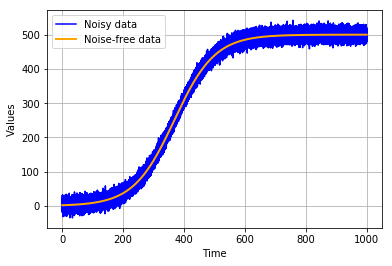

In [38]:
import matplotlib.pyplot as pl

pl.figure()
pl.xlabel('Time')
pl.ylabel('Values')
pl.plot(times, values, color='blue', label='Noisy data')
pl.plot(times, org_values, color='orange', lw=2, label='Noise-free data')
pl.legend()
pl.show()

Now we have enough data (a model, a list of times, and a list of data) to formulate a problem:

In [9]:
problem = pints.SingleSeriesProblem(model, times, values)

We now have some toy data, and a model that can be used for forward simulations. To make it into a probabilistic problem, we need to add a _noise model_. One way to do this is using the `UnknownNoiseLogLikelihood` function, which assumes independently distributed Gaussian noise over the data, and can calculate log-likelihoods:

In [10]:
log_likelihood = pints.UnknownNoiseLogLikelihood(problem)

This noise has mean zero, and an unknown standard deviation. How can we find out the standard deviation? By inferring it along with the other parameters. This means we have added one parameter to our problem!

In [12]:
print('Original problem dimension: ' + str(problem.dimension()))

Original problem dimension: 2


In [13]:
print('New dimension: ' + str(log_likelihood.dimension()))

New dimension: 3


(This means we also have to update our vector of true parameters)

In [17]:
true_parameters += [noise]
print(true_parameters)

[0.015, 500, 10]


This `log_likelihood` represents the _conditional probability_ $p(y|\theta)$, given a set of parameters $\theta$ and a series of $y=$ `values`, it can calculate the probability of finding those values if the real parameters are $\theta$.

We can use this in a Bayesian inference scheme to find the quantity we're interested in:

$p(\theta|y) = \frac{p(\theta)p(y|\theta)}{p(y)} \propto p(\theta)p(y|\theta)$

To solve this, we now define a _prior_, indicating our initial ideas about what the parameters should be. In this example we'll assume we don't know too much except lower and upper bounds for each variable: We assume the first model parameter is somewhere on the interval $[0.01, 0.02]$, the second model parameter on $[400, 600]$, and the standard deviation of the noise is somewhere on $[1, 100]$.

In [ ]:
prior = pints.UniformPrior(
    [0.01, 400, 1],
    [0.02, 600, 100]
    )

With this prior, we can now define a Bayesian likelihood $p(\theta)p(y|\theta)$

In [15]:
log_likelihood = pints.BayesianLogLikelihood(prior, log_likelihood)

And this, together with a guess at the true parameters, gives us everything we need to run an MCMC routine:

In [18]:
x0 = np.array(true_parameters) * 1.1
chain = pints.adaptive_covariance_mcmc(log_likelihood, x0)

Iteration 0 of 6000
  In burn-in: False
  Adapting: False
  Acceptance rate: 0.0
Iteration 50 of 6000
  In burn-in: False
  Adapting: False
  Acceptance rate: 0.0588235294118
Iteration 100 of 6000
  In burn-in: False
  Adapting: False
  Acceptance rate: 0.029702970297
Iteration 150 of 6000
  In burn-in: False
  Adapting: False
  Acceptance rate: 0.0264900662252
Iteration 200 of 6000
  In burn-in: False
  Adapting: False
  Acceptance rate: 0.0248756218905
Iteration 250 of 6000
  In burn-in: False
  Adapting: False
  Acceptance rate: 0.0239043824701
Iteration 300 of 6000
  In burn-in: False
  Adapting: False
  Acceptance rate: 0.0199335548173
Iteration 350 of 6000
  In burn-in: False
  Adapting: False
  Acceptance rate: 0.017094017094
Iteration 400 of 6000
  In burn-in: False
  Adapting: False
  Acceptance rate: 0.0149625935162
Iteration 450 of 6000
  In burn-in: False
  Adapting: False
  Acceptance rate: 0.0133037694013
Iteration 500 of 6000
  In burn-in: False
  Adapting: False
  Accep

/home/michael/dev/pints/pints/_mcmc/_adaptive.py:75: RuntimeWarning: covariance is not positive-semidefinite.
  np.exp(loga) * sigma)


Iteration 1550 of 6000
  In burn-in: False
  Adapting: True
  Acceptance rate: 0.0186976144423
Iteration 1600 of 6000
  In burn-in: False
  Adapting: True
  Acceptance rate: 0.0306058713304
Iteration 1650 of 6000
  In burn-in: False
  Adapting: True
  Acceptance rate: 0.0484554815263
Iteration 1700 of 6000
  In burn-in: False
  Adapting: True
  Acceptance rate: 0.0623162845385
Iteration 1750 of 6000
  In burn-in: False
  Adapting: True
  Acceptance rate: 0.0736721873215
Iteration 1800 of 6000
  In burn-in: False
  Adapting: True
  Acceptance rate: 0.0805108273182
Iteration 1850 of 6000
  In burn-in: False
  Adapting: True
  Acceptance rate: 0.0831982712048
Iteration 1900 of 6000
  In burn-in: False
  Adapting: True
  Acceptance rate: 0.0883745397159
Iteration 1950 of 6000
  In burn-in: False
  Adapting: True
  Acceptance rate: 0.0866222450026
Iteration 2000 of 6000
  In burn-in: False
  Adapting: True
  Acceptance rate: 0.0854572713643
Iteration 2050 of 6000
  In burn-in: False
  Adapt

Now we can plot samples from the resulting markov chains to approximate the distributions of the parameters:

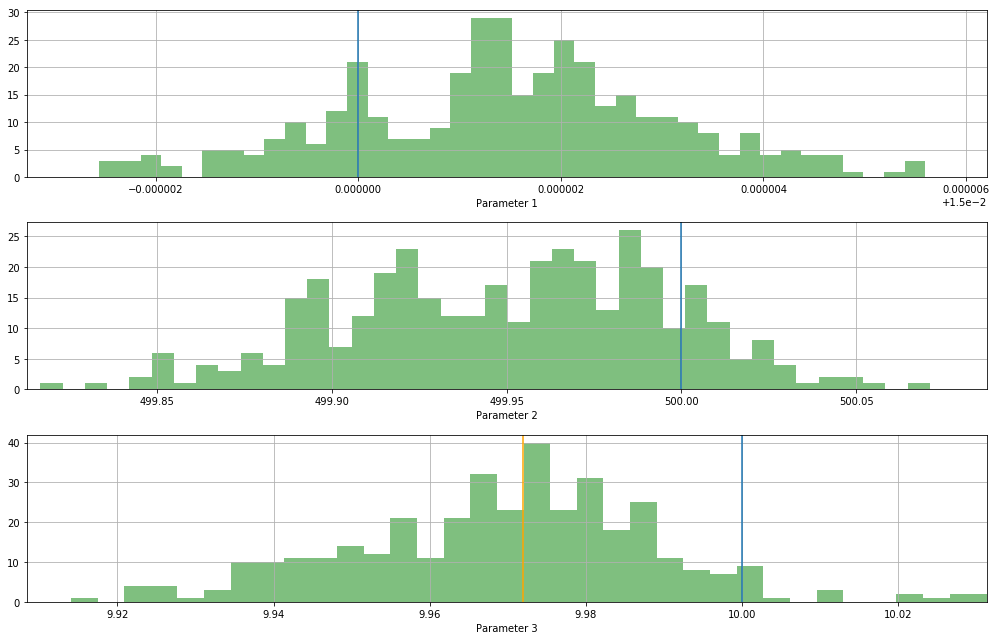

In [47]:
pl.figure(figsize=(14, 9))
for i, real in enumerate(true_parameters):
    
    # Add subplot
    pl.subplot(len(true_parameters), 1, 1+i)
    pl.xlabel('Parameter ' + str(i + 1))
    
    # Show true value
    pl.axvline(real)
    
    # Show histogram of chain
    pl.hist(chain[:,i], label='p' + str(i + 1), bins=40, color='green',
        alpha=0.5)
    
    # Center plot around mean of chain
    mu = np.mean(chain[:,i])
    sigma = np.std(chain[:,i])
    pl.xlim(mu - 3 * sigma, mu + 3 * sigma)

# Show where the sample standard deviation of the generated noise is:
pl.axvline(noise_sample_std, color='orange')

# Finalise plot
pl.tight_layout()
pl.show()

As these plots show, we came pretty close to the original "true" values (represented by the blue line).

But not exactly... Worse, the method seems to suggest a normal distribution but around the wrong point.

To find out what's going on, we can plot the log-likelihood function near the true parameters:

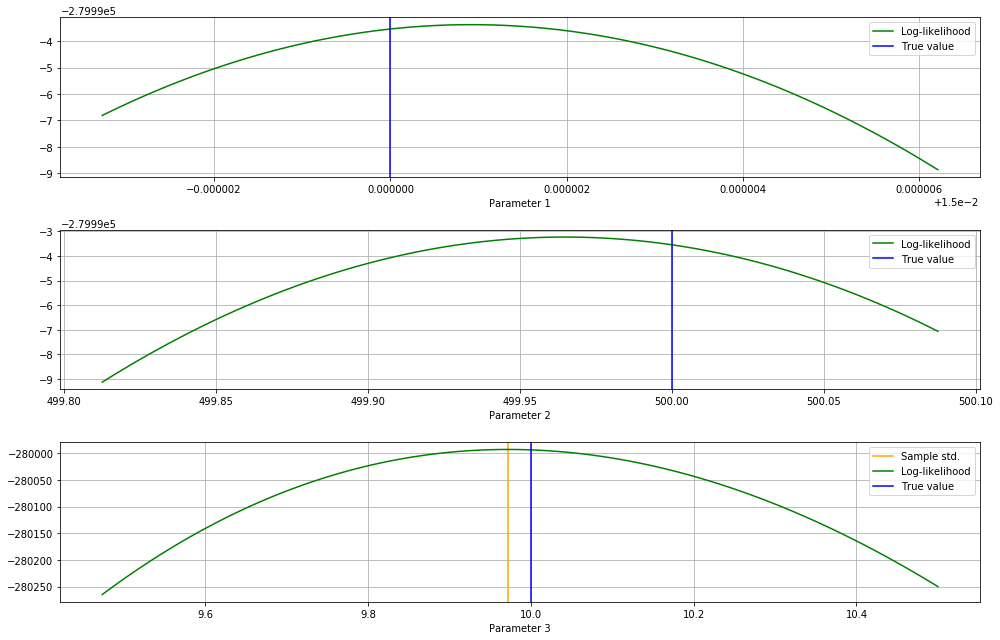

In [46]:
# Get properties of the noise sample
noise_sample_mean = np.mean(values - org_values)
noise_sample_std = np.std(values - org_values)

# Plot log-likelihood function
pl.figure(figsize=(14, 9))
for i, p in enumerate(true_parameters):
    # Add subplot
    pl.subplot(len(true_parameters), 1, 1 + i)
    pl.xlabel('Parameter ' + str(i + 1))
    # Generate some x-values near the true parameter
    if i + 1 == len(true_parameters):
        # Noise plot: special case
        # First, add a line showing the sample standard deviation of the
        # generated noise
        pl.axvline(noise_sample_std, color='orange', label='Sample std.')
        # Next, choose a wide range of parameters so we can see the peak of the
        # log-likelihood curve
        xmin = min([p*0.95, noise_sample_std*0.95])
        xmax = max([p*1.05, noise_sample_std*1.05])
    else:
        # Choose same limits as histogram (see below)
        mu = np.mean(chain[:,i])
        sigma = np.std(chain[:,i])
        xmin = mu - 3 * sigma
        xmax = mu + 3 * sigma
    x = np.linspace(xmin, xmax, 100)
    # Calculate log-likelihood with other parameters fixed
    y = [log_likelihood(list(true_parameters[:i]) + [j]
        + list(true_parameters[1+i:])) for j in x]
    # Plot
    pl.plot(x, y, color='green', label='Log-likelihood')
    pl.axvline(p, color='blue', label='True value')
    pl.legend()
pl.tight_layout()
pl.show()

As this plot (created entirely without MCMC!) shows, the MCMC method did well, but our estimate of the true parameters has become _biased_ by the stochastic noise! You can test this by increasing the number of sample points, which increases the size of the noise sample, and reduces the bias.